In [ ]:
#Caminhos desatualizados atualizar ainda
print("--- ETAPA DE CONFIGURAÇÃO MANUAL CONCLUÍDA ---")
print("As pastas 'training2017' e 'validation2017' devem estar no mesmo diretório que este notebook.")

In [ ]:
import tensorflow as tf
###bs2+ que tem a placa de video para rodar o modelo
###evn bs2+ rodar o modelo
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU detectada com sucesso pelo TensorFlow:")
    for gpu in gpus:
        print(f"  - Dispositivo: {gpu.name}")
else:
    print("ATENÇÃO: Nenhuma GPU foi detectada pelo TensorFlow.")

GPU detectada com sucesso pelo TensorFlow:
  - Dispositivo: /physical_device:GPU:0


Célula 1: Importações

In [1]:
# CÉLULA 1: IMPORTAÇÕES GLOBAIS

import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import warnings
import gc

warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


#### CÉLULA 2: CLASSE DE PRÉ-PROCESSAMENTO (ECGPREPROCESSOR)


In [ ]:
class ECGPreprocessor:
    def __init__(self, target_length=9000, cutoff_freq=30, sampling_rate=300, filter_order=6):
        self.target_length, self.cutoff_freq, self.sampling_rate, self.filter_order = target_length, cutoff_freq, sampling_rate, filter_order

    def _read_header_file(self, hea_path):
        with open(hea_path, 'r') as f: header_line = f.readline().strip()
        return {'sampling_frequency': int(header_line.split()[2])}

    def _read_mat_file(self, mat_path):
        try:
            mat_data = scipy.io.loadmat(mat_path)
            ecg_data = mat_data.get('val', next(v for k, v in mat_data.items() if not k.startswith('__')))
            return ecg_data.T if ecg_data.shape[0] > ecg_data.shape[1] else ecg_data
        except Exception: return None

    def _normalize_signal(self, signal):
        signal_min, signal_max = np.min(signal), np.max(signal)
        return np.zeros_like(signal) if (signal_max - signal_min) == 0 else (signal - signal_min) / (signal_max - signal_min)

    def _crop_or_expand_signal(self, signal):
        current_length = signal.shape[-1]
        if current_length == self.target_length: return signal
        if current_length > self.target_length: return signal[..., :self.target_length]
        num_repeats = (self.target_length // current_length) + 1
        return np.tile(signal, (1, num_repeats))[..., :self.target_length]

    def _apply_butterworth_filter(self, signal, sampling_rate):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = self.cutoff_freq / nyquist
        b, a = butter(self.filter_order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, signal, axis=-1)

    def process_record(self, record_path):
        
        mat_path = f"{record_path}.mat"
        
        if not os.path.exists(mat_path): 
            return None
            
        # taxa de amostragem definida na classe (300 Hz)
        sampling_rate = self.sampling_rate
        
        
        ecg_data = self._read_mat_file(mat_path)
        if ecg_data is None: return None
        
        signal = ecg_data[0, :].reshape(1, -1)
        resized = self._crop_or_expand_signal(signal)
        filtered = self._apply_butterworth_filter(resized, sampling_rate)
        return filtered

    def _load_labels(self, csv_path):
        try: 
            return pd.read_csv(csv_path, header=None)
        except Exception as e:
            print(f"Erro ao ler o CSV: {e}")
            return None

    def process_and_save_dataset(self, data_dir, csv_path, output_dir, augment=False):
        labels_df = self._load_labels(csv_path)
        if labels_df is None: return print(f"ERRO: Nao foi possivel carregar '{csv_path}'")
        
        augmentation_factors = {'A': 3, 'O': 2, 'N': 1, '~': 1}
        processed_data, processed_labels = [], []
        set_type = "TREINO (com aumento)" if augment else "VALIDACAO (sem aumento)"
        print(f"\n--- Processando {len(labels_df)} registros para o conjunto de {set_type} ---")
        
        for _, row in labels_df.iterrows():
            record_name, label = row.iloc[0], row.iloc[1]
            base_signal = self.process_record(os.path.join(data_dir, record_name))
            if base_signal is not None:
                num_copies = augmentation_factors.get(label, 1) if augment else 1
                for i in range(num_copies):
                    signal_to_add = np.copy(base_signal)
                    if augment and i > 0: signal_to_add += np.random.normal(0, 0.02 * np.std(signal_to_add), signal_to_add.shape)
                    processed_data.append(self._normalize_signal(signal_to_add)[0])
                    processed_labels.append(label)

        print(f"Processamento concluido. Total de amostras geradas: {len(processed_data)}")
        os.makedirs(output_dir, exist_ok=True)
        np.save(os.path.join(output_dir, 'processed_signals.npy'), np.array(processed_data))
        pd.DataFrame({'Label': processed_labels}).to_csv(os.path.join(output_dir, 'processed_labels.csv'), index=False)
        print(f"Dados salvos em '{output_dir}'")

CÉLULA 3: VALIDAÇÃO DOS DADOS PRÉ-PROCESSADOS

In [ ]:
# CÉLULA 3: EXECUÇÃO DO PRÉ-PROCESSAMENTO DE DADOS

# Diretório base que contém as pastas 'training2017' e 'validation2017'
BASE_DE_DADOS_DIR = os.path.join("..", "basededados")

# Caminhos para os diretórios de treinamento e validação
TRAINING_DIR = os.path.join(BASE_DE_DADOS_DIR, "training2017")
VALIDATION_DIR = os.path.join(BASE_DE_DADOS_DIR, "validation2017")

TRAINING_LABELS_CSV = os.path.join(TRAINING_DIR, "REFERENCE-original.csv")
VALIDATION_LABELS_CSV = os.path.join(VALIDATION_DIR, "REFERENCE.csv")

TRAINING_OUTPUT_DIR = "processed_data/training"
VALIDATION_OUTPUT_DIR = "processed_data/validation"


print(f"Buscando dados de treinamento em: {os.path.abspath(TRAINING_DIR)}")
print(f"Buscando dados de validação em: {os.path.abspath(VALIDATION_DIR)}")
print(f"Salvando dados processados de treinamento em: {os.path.abspath(TRAINING_OUTPUT_DIR)}")
print("-" * 30)

preprocessor = ECGPreprocessor()
preprocessor.process_and_save_dataset(TRAINING_DIR, TRAINING_LABELS_CSV, TRAINING_OUTPUT_DIR, augment=True)
preprocessor.process_and_save_dataset(VALIDATION_DIR, VALIDATION_LABELS_CSV, VALIDATION_OUTPUT_DIR, augment=False)

print("\nEtapa de pré-processamento concluída.")

INICIANDO SCRIPT DE VERIFICACAO DOS DADOS DE TREINAMENTO
Carregando dados processados de 'processed_data/training'...
Carregando referência original de '..\basededados\training2017\REFERENCE-original.csv'...
Arquivos carregados com sucesso.

--- RELATORIO DE VALIDACAO DO CONJUNTO DE TREINO ---

[1] Consistencia de Tamanho:
    - Sinais processados: 12627
    - Rotulos processados: 12627
    -> Status: OK

[2] Comprimento dos Sinais:
    - Comprimento de cada sinal: 9000
    -> Status: OK

[3] Verificacao de Normalizacao:
    - Valor minimo global: -1.0000
    - Valor maximo global: 1.0000
    -> Status: OK

[4] Comparacao de Balanceamento de Classes:
    -----------------|-----------|--------------------------
    Classe           |  Original |  Processado (Aumentado)
    -----------------|-----------|--------------------------
    'A'              | 771       | 2313
    'N'              | 5154      | 5154
    'O'              | 2557      | 5114
    '~'              | 46        | 46
  

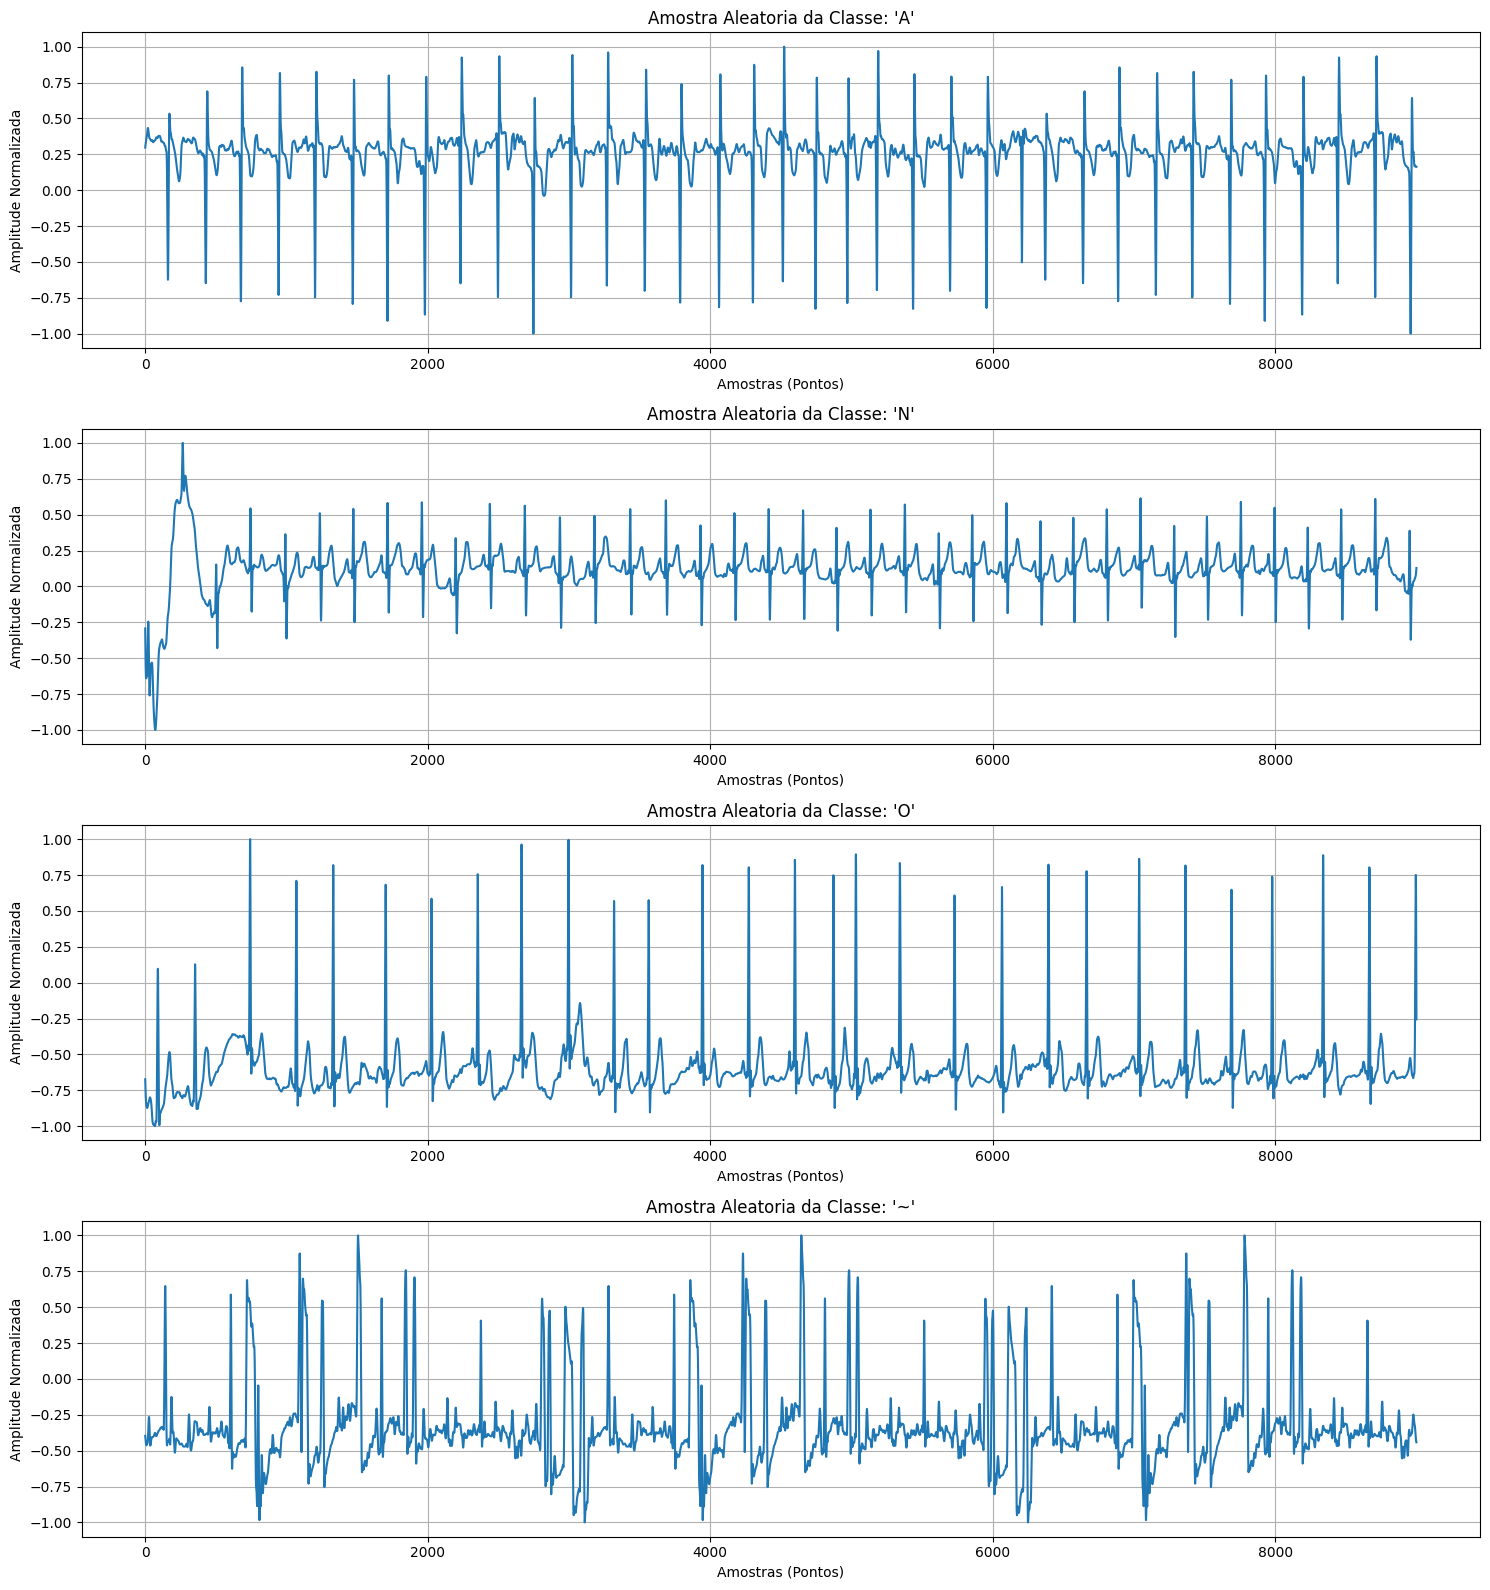


VERIFICACAO CONCLUIDA


In [5]:
# CÉLULA 4: VERIFICAÇÃO E VISUALIZAÇÃO DOS DADOS PROCESSADOS (GRÁFICOS POR CLASSE)

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import Counter

print("="*60)
print("INICIANDO SCRIPT DE VERIFICACAO DOS DADOS DE TREINAMENTO")
print("="*60)

# --- Caminhos para os arquivos de treino ---
TRAINING_OUTPUT_DIR = "processed_data/training"

# O caminho original apontava para o Google Colab (/content/...).
ORIGINAL_TRAINING_LABELS_PATH = os.path.join("..", "basededados", "training2017", "REFERENCE-original.csv")

train_signals_path = os.path.join(TRAINING_OUTPUT_DIR, 'processed_signals.npy')
train_labels_path = os.path.join(TRAINING_OUTPUT_DIR, 'processed_labels.csv')


try:
    print(f"Carregando dados processados de '{TRAINING_OUTPUT_DIR}'...")
    print(f"Carregando referência original de '{ORIGINAL_TRAINING_LABELS_PATH}'...")
    train_signals = np.load(train_signals_path)
    train_labels_df = pd.read_csv(train_labels_path)
    train_labels = train_labels_df['Label'].values
    print("Arquivos carregados com sucesso.")

    # --- 1. Relatório de Verificação ---
    print("\n--- RELATORIO DE VALIDACAO DO CONJUNTO DE TREINO ---")

    # Consistência
    print(f"\n[1] Consistencia de Tamanho:")
    print(f"    - Sinais processados: {train_signals.shape[0]}")
    print(f"    - Rotulos processados: {len(train_labels)}")
    if train_signals.shape[0] == len(train_labels):
        print("    -> Status: OK")
    else:
        print("    -> Status: FALHA")

    # Comprimento
    print(f"\n[2] Comprimento dos Sinais:")
    print(f"    - Comprimento de cada sinal: {train_signals.shape[1]}")
    if train_signals.shape[1] == 9000:
        print("    -> Status: OK")
    else:
        print("    -> Status: FALHA")

    # Normalização
    min_val, max_val = np.min(train_signals), np.max(train_signals)
    print(f"\n[3] Verificacao de Normalizacao:")
    print(f"    - Valor minimo global: {min_val:.4f}")
    print(f"    - Valor maximo global: {max_val:.4f}")
    if min_val >= -1.0 and max_val <= 1.0:
        print("    -> Status: OK")
    else:
        print("    -> Status: AVISO (Valores fora do intervalo [-1, 1])")

    # Balanceamento
    print("\n[4] Comparacao de Balanceamento de Classes:")
    original_df = pd.read_csv(ORIGINAL_TRAINING_LABELS_PATH, header=None) # Adicionado header=None por segurança
    original_counts = Counter(original_df.iloc[:, 1])
    processed_counts = Counter(train_labels)

    print("    -----------------|-----------|--------------------------")
    print("    Classe           |  Original |  Processado (Aumentado)")
    print("    -----------------|-----------|--------------------------")
    for label in sorted(processed_counts.keys()):
        print(f"    '{label}'              | {original_counts.get(label, 0):<9} | {processed_counts.get(label, 0)}")
    print("    -----------------|-----------|--------------------------")

    # --- 2. Geração dos Gráficos (um por classe) ---
    if len(train_signals) > 0:
        print("\n--- VISUALIZACAO DE AMOSTRAS ALEATORIAS (UMA POR CLASSE) ---")

        unique_labels = np.unique(train_labels)

        # Cria uma figura com um subplot para cada classe
        fig, axes = plt.subplots(
            len(unique_labels), 1,
            figsize=(15, 4 * len(unique_labels)),
            squeeze=False
        )

        for i, label in enumerate(unique_labels):
            # Encontra todos os índices para a classe atual
            indices = np.where(train_labels == label)[0]
            # Escolhe um índice aleatório dentro dessa classe
            random_index = np.random.choice(indices)

            ax = axes[i, 0] # Seleciona o subplot correto
            ax.plot(train_signals[random_index])
            ax.set_title(f"Amostra Aleatoria da Classe: '{label}'")
            ax.set_xlabel('Amostras (Pontos)')
            ax.set_ylabel('Amplitude Normalizada')
            ax.grid(True) # Adiciona a grade ao gráfico

        plt.tight_layout() # Ajusta o layout para evitar sobreposição
        plt.show()
    else:
        print("\nNao ha dados de treinamento para plotar.")

except FileNotFoundError as e:
    print(f"\nERRO: Nao foi possivel encontrar um dos arquivos necessarios.")
    print(f"Arquivo não encontrado: {e.filename}")
    print(f"Verifique se a celula de pre-processamento (Célula 3) foi executada com sucesso.")
    print(f"Verifique também se os caminhos no início desta célula estão corretos para a estrutura de pastas do seu computador.")

print("\n" + "="*60)
print("VERIFICACAO CONCLUIDA")
print("="*60)

### Célula 5 Arquitetura do Modelo

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class KB2SPlusModel(keras.Model):
    def __init__(self, input_shape, num_classes):
        super(KB2SPlusModel, self).__init__()
        self.input_shape_data = input_shape
        self.num_classes = num_classes

        # Path 1 (K=2)

        self.conv1_1 = layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape, padding='same', name='conv1_1_k2')
        self.bn1_1 = layers.BatchNormalization(name='bn1_1_k2')
        self.pool1_1 = layers.MaxPooling1D(pool_size=2, name='pool1_1_k2')

        self.conv1_2 = layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', name='conv1_2_k2')
        self.bn1_2 = layers.BatchNormalization(name='bn1_2_k2')
        self.pool1_2 = layers.MaxPooling1D(pool_size=2, name='pool1_2_k2')

        # Path 2 (K=3)
        self.conv2_1 = layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', name='conv2_1_k3')
        self.bn2_1 = layers.BatchNormalization(name='bn2_1_k3')
        self.pool2_1 = layers.MaxPooling1D(pool_size=2, name='pool2_1_k3')


        self.conv2_2 = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv2_2_k3')
        self.bn2_2 = layers.BatchNormalization(name='bn2_2_k3')
        self.pool2_2 = layers.MaxPooling1D(pool_size=2, name='pool2_2_k3')

        # Path 3 (K=5)
 
        self.conv3_1 = layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same', name='conv3_1_k5')
        self.bn3_1 = layers.BatchNormalization(name='bn3_1_k5')
        self.pool3_1 = layers.MaxPooling1D(pool_size=2, name='pool3_1_k5')


        self.conv3_2 = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', name='conv3_2_k5')
        self.bn3_2 = layers.BatchNormalization(name='bn3_2_k5')
        self.pool3_2 = layers.MaxPooling1D(pool_size=2, name='pool3_2_k5')

        # Camadas Dense Finais (APÓS CONCATENAÇÃO E FLATTEN ÚNICO)
        self.flatten = layers.Flatten(name='flatten') # Flatten ÚNICO aqui
        self.dense1 = layers.Dense(128, activation='relu', name='dense1')
        self.dropout1 = layers.Dropout(0.5, name='dropout1')
        self.dense2 = layers.Dense(64, activation='relu', name='dense2')
        self.dropout2 = layers.Dropout(0.3, name='dropout2')
        self.output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')

    def call(self, inputs):
        # Path 1
        x1 = self.conv1_1(inputs)
        x1 = self.bn1_1(x1)
        x1 = self.pool1_1(x1)
        x1 = self.conv1_2(x1)
        x1 = self.bn1_2(x1)
        x1 = self.pool1_2(x1)

        # Path 2
        x2 = self.conv2_1(inputs)
        x2 = self.bn2_1(x2)
        x2 = self.pool2_1(x2)
        x2 = self.conv2_2(x2)
        x2 = self.bn2_2(x2)
        x2 = self.pool2_2(x2)

        # Path 3
        x3 = self.conv3_1(inputs)
        x3 = self.bn3_1(x3)
        x3 = self.pool3_1(x3)
        x3 = self.conv3_2(x3)
        x3 = self.bn3_2(x3)
        x3 = self.pool3_2(x3)

        # Concatenate all paths (ainda em formato 3D)
        concatenated = layers.concatenate([x1, x2, x3], axis=-1)

        # Achatamento ÚNICO após a concatenação
        flattened = self.flatten(concatenated)

        # Camadas Dense com Dropouts
        x = self.dense1(flattened)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        output = self.output_layer(x)
        return output

    def build_and_compile(self, learning_rate=5e-5):
        dummy_input = tf.keras.Input(shape=self.input_shape_data)
        _ = self.call(dummy_input)

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return self

    def train_model(self, X_train, y_train, X_val, y_val, epochs=45, batch_size=32, class_weights=None, callbacks=None):
        if callbacks is None:
             callbacks = [
                keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            ]
        history = self.fit(X_train, y_train,
                           epochs=epochs,
                           batch_size=batch_size,
                           validation_data=(X_val, y_val),
                           callbacks=callbacks,
                           class_weight=class_weights,
                           verbose=1)
        return history
    

class MetricsEvaluator:
    def __init__(self, class_names):
        """
        Inicializa o avaliador de métricas.

        Args:
            class_names (list): Uma lista de strings com os nomes das classes na ordem correta,
                                 correspondendo aos rótulos codificados numericamente.
        """
        self.class_names = class_names

    def show_all_metrics(self, y_true, y_pred_proba, history):

        # Converte probabilidades para rótulos preditos (argmax)
        y_pred = np.argmax(y_pred_proba, axis=1)

        print("\n--- RELATORIO DE CLASSIFICACAO DETALHADO ---")
        # Ensure that y_true and y_pred contain labels within the range of class_names
        # and handle zero_division gracefully.
        print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

        print("\n--- MATRIZ DE CONFUSAO ---")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Previsto')
        plt.ylabel('Real')
        plt.title('Matriz de Confusão')
        plt.show()

        print("\n--- CURVA ROC E AUC ---")
        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(self.class_names):
            # Check if the class actually exists in y_true to avoid errors with roc_curve
            if np.sum(y_true == i) > 0:
                fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'ROC {class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
        plt.xlabel('Taxa de Falso Positivo (FPR)')
        plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
        plt.title('Curva ROC para Cada Classe')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        print("\n--- CURVAS DE APRENDIZADO ---")
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Acurácia de Treino')
        plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
        plt.title('Curvas de Acurácia')
        plt.xlabel('Época')
        plt.ylabel('Acurácia')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Loss de Treino')
        plt.plot(history.history['val_loss'], label='Loss de Validação')
        plt.title('Curvas de Loss')
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

### CÉLULA 6: PIPELINE DE TREINAMENTO E AVALIAÇÃO


--- [ETAPA 1/3] Carregando e preparando dados ---
Forma dos dados de treino (X): (12627, 9000, 1)
Número de classes: 4
Nomes das classes: ['A', 'N', 'O', '~']

--- [ETAPA 2/3] Construindo e treinando o modelo ---
Model: "kb2s_plus_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1_k2 (Conv1D)         (None, 9000, 32)          96        
                                                                 
 bn1_1_k2 (BatchNormalizatio  (None, 9000, 32)         128       
 n)                                                              
                                                                 
 pool1_1_k2 (MaxPooling1D)   (None, 4500, 32)          0         
                                                                 
 conv1_2_k2 (Conv1D)         (None, 4500, 64)          4160      
                                                                 
 bn1_2_k2 (BatchNormalizatio  (None

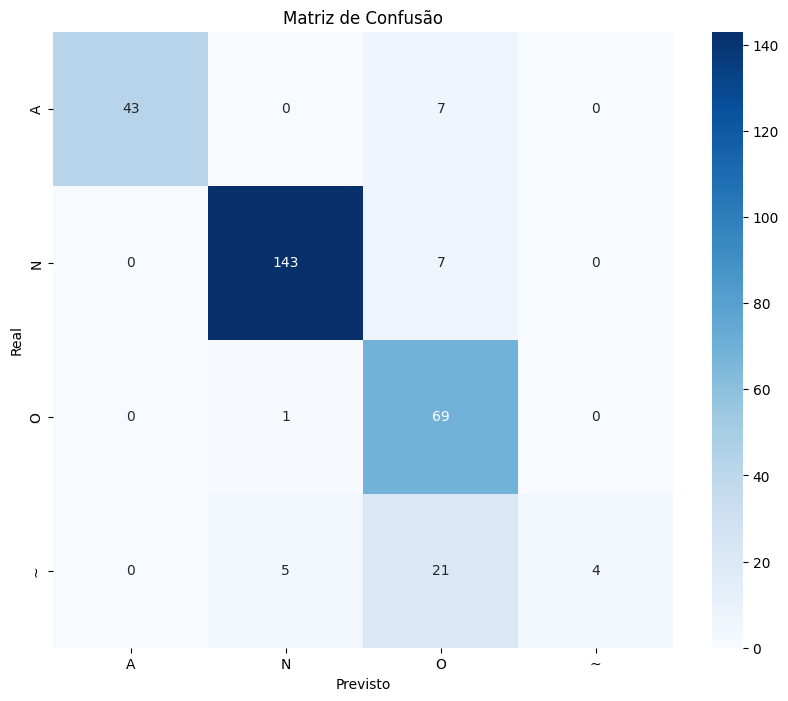


--- CURVA ROC E AUC ---


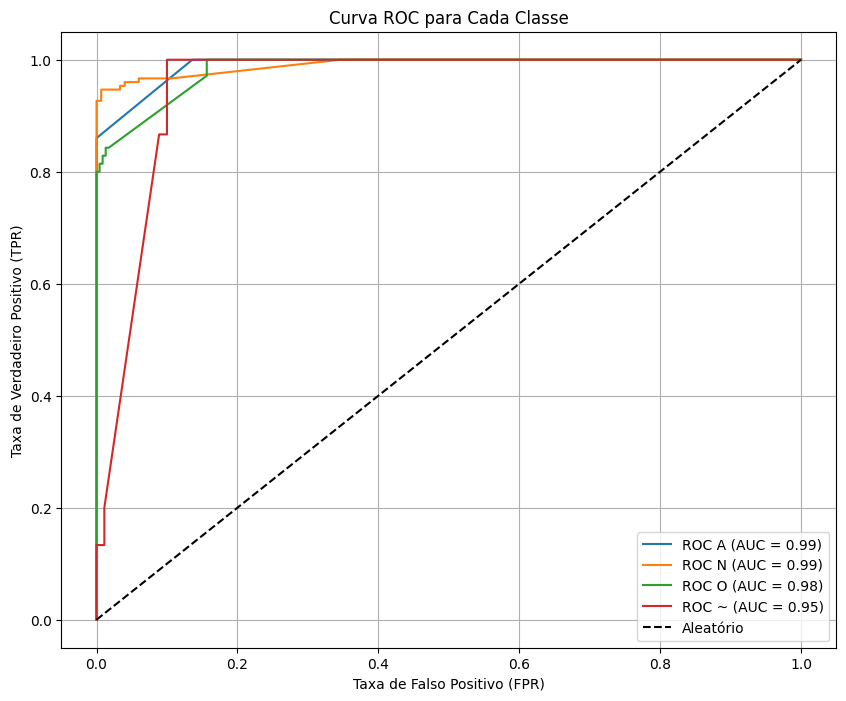


--- CURVAS DE APRENDIZADO ---


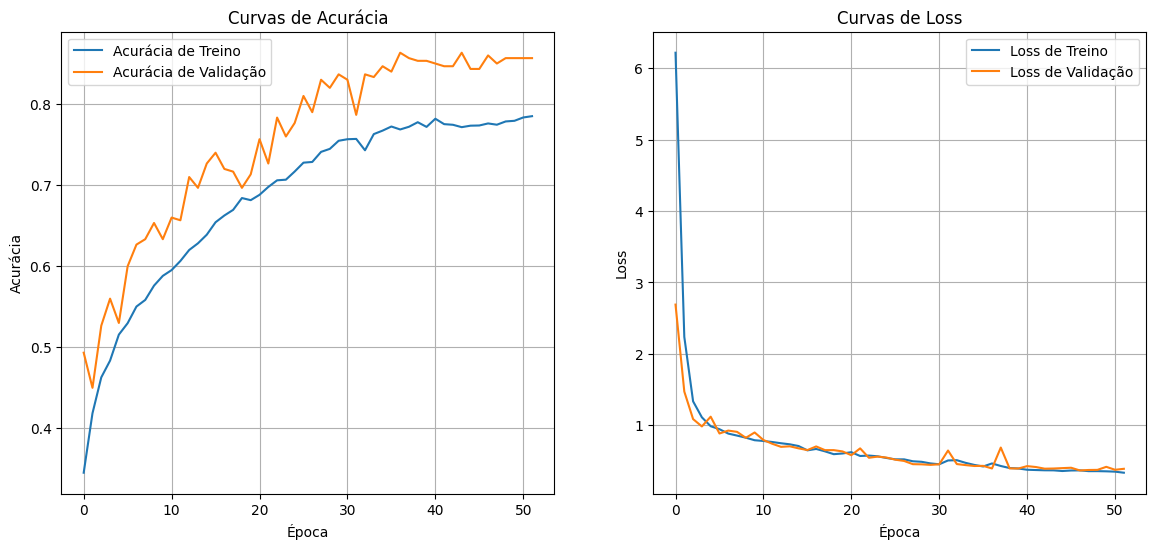


Pipeline completo finalizado!


In [ ]:
print("\n--- [ETAPA 1/3] Carregando e preparando dados ---")
X_train = np.load('processed_data/training/processed_signals.npy')
y_train_labels = pd.read_csv('processed_data/training/processed_labels.csv')['Label'].values
X_val = np.load('processed_data/validation/processed_signals.npy')
y_val_labels = pd.read_csv('processed_data/validation/processed_labels.csv')['Label'].values

# Expande as dimensões para o formato esperado pela CNN (amostras, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Codifica os rótulos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_val = label_encoder.transform(y_val_labels)
class_names = list(label_encoder.classes_)
num_classes = len(class_names)
print(f"Forma dos dados de treino (X): {X_train.shape}")
print(f"Número de classes: {num_classes}")
print(f"Nomes das classes: {class_names}")

print("\n--- [ETAPA 2/3] Construindo e treinando o modelo ---")
# Instancia o modelo
model_builder = KB2SPlusModel(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)

# Compila o modelo com a learning rate ajustada
model = model_builder.build_and_compile(learning_rate=0.00005)

# Constrói o modelo explicitamente antes de chamar summary()
model.build((None, X_train.shape[1], X_train.shape[2]))
model.summary()

# --- CÁLCULO DOS PESOS DE CLASSE - CORREÇÃO APLICADA AQUI PARA SUAVIZAR A CLASSE '~' ---
train_counts = np.bincount(y_train)
class_weights = {}
total_samples_in_train = len(y_train)

# Encontra o índice numérico da classe '~'
# Se 'N', 'A', 'O', '~' 
idx_other_class = -1 # Valor padrão, será atualizado
if '~' in class_names:
    idx_other_class = label_encoder.transform(['~'])[0]

manual_weight_for_other = 4.0

for i, count in enumerate(train_counts):
    if i == idx_other_class:
        # Atribui o peso manual para a classe '~'
        class_weights[i] = manual_weight_for_other
    elif count > 0:
        # Calcula o peso inverso da frequência para as outras classes
        class_weights[i] = total_samples_in_train / (num_classes * count)
    else:
        # Para classes que não aparecem no treino (improvável para A,N,O)
        class_weights[i] = 0.0

print(f"Pesos de classe calculados: {class_weights}")
print(f"Peso aplicado para a classe '{class_names[idx_other_class]}' ('~'): {manual_weight_for_other}")


# Define os callbacks para o treinamento
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True), # Aumentei a paciência
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6) # Aumentei a paciência
]

# Treina o modelo com o batch_size de 32 e os callbacks (mantendo 32 por questão de memória)
history = model_builder.train_model(X_train, y_train, X_val, y_val,
                                   epochs=150, 
                                   batch_size=32, 
                                   class_weights=class_weights,
                                   callbacks=callbacks)

print("\n--- [ETAPA 3/3] Avaliando o modelo treinado ---")
evaluator = MetricsEvaluator(class_names)
y_pred_proba = model.predict(X_val)
evaluator.show_all_metrics(y_val, y_pred_proba, history)

print("\nPipeline completo finalizado!")

### Célula 7 salvar o modelo

In [ ]:
# CÉLULA 7: Salvar o Modelo Treinado (CORRIGIDA PARA SUBCLASSING MODEL)

import os
import tensorflow as tf # Certifique-se que tensorflow está importado

# Define o diretório onde o modelo será salvo
model_save_dir = "saved_models"
os.makedirs(model_save_dir, exist_ok=True)

model_path = os.path.join(model_save_dir, "ecg_cnn_model_tf") # Altera a extensão para um diretório

print(f"Salvando o modelo no formato TensorFlow SavedModel em: {model_path}...")
model.save(model_path, save_format='tf') 
print("Modelo salvo com sucesso no formato TensorFlow SavedModel!")

# Opcional: Você pode querer salvar o label_encoder também, para garantir que as classes
# sejam interpretadas da mesma forma quando o modelo for carregado mais tarde.
import pickle
label_encoder_path = os.path.join(model_save_dir, "label_encoder.pkl")
with open(label_encoder_path, 'wb') as file:
    pickle.dump(label_encoder, file)
print(f"LabelEncoder salvo em: {label_encoder_path}")

Salvando o modelo no formato TensorFlow SavedModel em: saved_models\ecg_cnn_model_tf...


INFO:tensorflow:Assets written to: saved_models\ecg_cnn_model_tf\assets


INFO:tensorflow:Assets written to: saved_models\ecg_cnn_model_tf\assets


Modelo salvo com sucesso no formato TensorFlow SavedModel!
LabelEncoder salvo em: saved_models\label_encoder.pkl


### Célula 8 carrega modelo

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import pickle
import os

# Caminho onde o modelo e o label_encoder foram salvos
model_save_dir = "saved_models"
model_path_tf = os.path.join(model_save_dir, "ecg_cnn_model_tf") # Caminho para o diretório do SavedModel
label_encoder_path = os.path.join(model_save_dir, "label_encoder.pkl")

print(f"Carregando o modelo do formato TensorFlow SavedModel de: {model_path_tf}...")
loaded_model = keras.models.load_model(model_path_tf) 
print("Modelo carregado com sucesso!")

print(f"Carregando o LabelEncoder de: {label_encoder_path}...")
with open(label_encoder_path, 'rb') as file:
    loaded_label_encoder = pickle.load(file)
print("LabelEncoder carregado com sucesso!")

loaded_class_names = list(loaded_label_encoder.classes_)
print(f"Nomes das classes carregadas: {loaded_class_names}")

Carregando o modelo do formato TensorFlow SavedModel de: saved_models\ecg_cnn_model_tf...
Modelo carregado com sucesso!
Carregando o LabelEncoder de: saved_models\label_encoder.pkl...
LabelEncoder carregado com sucesso!
Nomes das classes carregadas: ['A', 'N', 'O', '~']


### Celula 9 testa modelo

1/1 [==============================] - 0s 18ms/step

--- Teste de Amostra Única (Índice: 233) ---
Rótulo VERDADEIRO da amostra: N
Rótulo PREVISTO pelo modelo: N
Probabilidades de Previsão para cada classe (['A', 'N', 'O', '~']):
  - A: 0.0012
  - N: 0.9933
  - O: 0.0055
  - ~: 0.0001


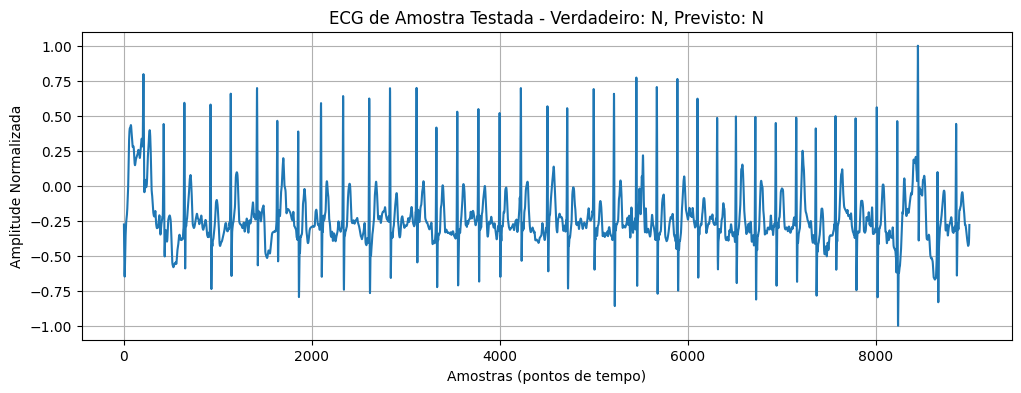

In [18]:
X_val_full = np.load('processed_data/validation/processed_signals.npy')
y_val_labels_full = pd.read_csv('processed_data/validation/processed_labels.csv')['Label'].values

# Expanda as dimensões para o formato da CNN
X_val_full = np.expand_dims(X_val_full, axis=-1)

# Escolha um índice aleatório para testar (ou um específico que você queira verificar)
test_sample_index = np.random.randint(0, len(X_val_full))
# test_sample_index = 50 # Exemplo: para pegar uma amostra específica

sample_to_predict = X_val_full[test_sample_index]
true_label_str = y_val_labels_full[test_sample_index] # Rótulo original da amostra

# O modelo espera um batch de dados, então precisamos adicionar uma dimensão extra para o batch
sample_to_predict_batch = np.expand_dims(sample_to_predict, axis=0) # Transforma (9000, 1) em (1, 9000, 1)

# Realiza a predição
predictions = loaded_model.predict(sample_to_predict_batch)

# As previsões são probabilidades para cada classe
predicted_probabilities = predictions[0] # Pega o array de probabilidades para a primeira (e única) amostra no batch

# Encontra a classe com a maior probabilidade
predicted_class_index = np.argmax(predicted_probabilities)

# Converte o índice previsto de volta para o nome da classe usando o LabelEncoder
predicted_label_str = loaded_label_encoder.inverse_transform([predicted_class_index])[0]

print(f"\n--- Teste de Amostra Única (Índice: {test_sample_index}) ---")
print(f"Rótulo VERDADEIRO da amostra: {true_label_str}")
print(f"Rótulo PREVISTO pelo modelo: {predicted_label_str}")
print(f"Probabilidades de Previsão para cada classe ({loaded_class_names}):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  - {loaded_class_names[i]}: {prob:.4f}")

# Opcional: Visualizar o sinal de ECG da amostra
plt.figure(figsize=(12, 4))
plt.plot(sample_to_predict.flatten()) # .flatten() para remover a dimensão de features=1
plt.title(f"ECG de Amostra Testada - Verdadeiro: {true_label_str}, Previsto: {predicted_label_str}")
plt.xlabel("Amostras (pontos de tempo)")
plt.ylabel("Amplitude Normalizada")
plt.grid(True)
plt.show()

### K fold

In [22]:
import scipy.io
from scipy.signal import butter, filtfilt
import os
import gc

warnings.filterwarnings('ignore')


print("--- INICIANDO VALIDAÇÃO CRUZADA DE 10 FOLDS ---")
print("AVISO: Este processo pode ser muito demorado e intensivo em memória da GPU/RAM.")
print("É altamente recomendado reiniciar o kernel (Kernel -> Restart) antes de rodar esta célula.")


try:
    PROCESSED_TRAINING_SIGNALS = 'processed_data/training/processed_signals.npy'
    PROCESSED_TRAINING_LABELS = 'processed_data/training/processed_labels.csv'
    PROCESSED_VALIDATION_SIGNALS = 'processed_data/validation/processed_signals.npy'
    PROCESSED_VALIDATION_LABELS = 'processed_data/validation/processed_labels.csv'

    X_train_processed = np.load(PROCESSED_TRAINING_SIGNALS)
    y_train_processed_labels = pd.read_csv(PROCESSED_TRAINING_LABELS)['Label'].values

    X_val_processed = np.load(PROCESSED_VALIDATION_SIGNALS)
    y_val_processed_labels = pd.read_csv(PROCESSED_VALIDATION_LABELS)['Label'].values

    print(f"Dados de treino processados carregados: {X_train_processed.shape} amostras.")
    print(f"Dados de validação processados carregados: {X_val_processed.shape} amostras.")

    all_signals_kf = np.concatenate((X_train_processed, X_val_processed), axis=0)
    all_labels_kf = np.concatenate((y_train_processed_labels, y_val_processed_labels), axis=0)

    print(f"\nTotal de amostras combinadas para validação cruzada: {len(all_signals_kf)}")
    print(f"Forma dos dados combinados: {all_signals_kf.shape}")

    if all_signals_kf.ndim == 2:
        all_signals_kf = np.expand_dims(all_signals_kf, axis=-1)
        print(f"Forma dos dados combinados após expand_dims: {all_signals_kf.shape}")

    label_encoder_kf = LabelEncoder()
    y_encoded_kf = label_encoder_kf.fit_transform(all_labels_kf)
    class_names_kf = list(label_encoder_kf.classes_)
    num_classes_kf = len(class_names_kf)
    print(f"Nomes das classes para K-Fold: {class_names_kf}")
    print(f"Número de classes para K-Fold: {num_classes_kf}")


    n_splits = 10
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results_f1_per_class = []
    fold_histories = []

    kf_callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
    ]

    manual_weight_for_other_kf = 4.0
    idx_other_class_kf = -1
    if '~' in class_names_kf:
        idx_other_class_kf = label_encoder_kf.transform(['~'])[0]


    for fold, (train_idx, val_idx) in enumerate(skf.split(all_signals_kf, y_encoded_kf)):
        print("\n" + "="*70)
        print(f"Iniciando Fold {fold + 1}/{n_splits}")
        print("="*70)

        X_train_fold = all_signals_kf[train_idx]
        y_train_fold = y_encoded_kf[train_idx]
        X_val_fold = all_signals_kf[val_idx]
        y_val_fold = y_encoded_kf[val_idx]

        model_builder_kf = KB2SPlusModel(input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]), num_classes=num_classes_kf)
        model_kf = model_builder_kf.build_and_compile(learning_rate=0.00005)
        model_kf.build((None, X_train_fold.shape[1], X_train_fold.shape[2]))

        train_counts_fold = np.bincount(y_train_fold)
        class_weights_fold = {}
        total_samples_in_fold_train = len(y_train_fold)

        for i, count in enumerate(train_counts_fold):
            if i == idx_other_class_kf:
                class_weights_fold[i] = manual_weight_for_other_kf
            elif count > 0:
                class_weights_fold[i] = total_samples_in_fold_train / (num_classes_kf * count)
            else:
                class_weights_fold[i] = 0.0

        print(f"Pesos de classe para o Fold {fold + 1}: {class_weights_fold}")

        print(f"\nIniciando treinamento do Fold {fold + 1}...")
        history_kf = model_builder_kf.train_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold,
                                                 epochs=100,
                                                 batch_size=32,
                                                 class_weights=class_weights_fold,
                                                 callbacks=kf_callbacks)
        fold_histories.append(history_kf)

        y_pred_proba_fold = model_kf.predict(X_val_fold)
        y_pred_fold = np.argmax(y_pred_proba_fold, axis=1)

        f1_scores_fold = f1_score(y_val_fold, y_pred_fold, average=None, labels=range(num_classes_kf), zero_division=0)
        fold_results_f1_per_class.append(f1_scores_fold)

        print(f"--- F1-Scores para o Fold {fold + 1}: {f1_scores_fold} ---")

        del model_kf, model_builder_kf
        del X_train_fold, y_train_fold, X_val_fold, y_val_fold
        del class_weights_fold
        gc.collect()
        keras.backend.clear_session()


except Exception as main_e:
    print(f"\nERRO FATAL DURANTE A VALIDAÇÃO CRUZADA: {main_e}")
    import traceback
    traceback.print_exc()
    print("\nA validação cruzada não foi concluída com sucesso. Por favor, verifique os caminhos dos dados, a estrutura dos arquivos e a fase de pré-processamento.")


if 'fold_results_f1_per_class' in locals() and len(fold_results_f1_per_class) == n_splits:
    print("\n\n" + "="*70)
    print("RESULTADO FINAL DA VALIDAÇÃO CRUZADA DE 10 FOLDS (F1-Score por Classe)")
    print("="*70)

    results_array = np.array(fold_results_f1_per_class)
    mean_f1_per_class = np.mean(results_array, axis=0)
    std_f1_per_class = np.std(results_array, axis=0)

    print("\nF1-Score Médio por classe (10 Folds):")
    print("--------------------------------------------------")
    for i, class_name in enumerate(class_names_kf):
        print(f"  - Classe '{class_name}': {mean_f1_per_class[i]:.3f} (+- {std_f1_per_class[i]:.3f})")
    print("--------------------------------------------------")

    if '~' in class_names_kf:
        idx_other_class_for_mean = label_encoder_kf.transform(['~'])[0]
        mean_f1_overall_excluding_tilde = np.mean([score for i, score in enumerate(mean_f1_per_class) if i != idx_other_class_for_mean])
        print(f"\nF1-Score Médio Geral (excluindo classe '{class_names_kf[idx_other_class_for_mean]}'): {mean_f1_overall_excluding_tilde:.3f}")
    else:
        mean_f1_overall = np.mean(mean_f1_per_class)
        print(f"\nF1-Score Médio Geral (todas as classes): {mean_f1_overall:.3f}")

    print("\n" + "="*70)
    print("VALIDAÇÃO CRUZADA CONCLUÍDA")
    print("="*70)
else:
    print("\nA validação cruzada não foi concluída com sucesso em todos os folds. Nenhum resultado final a ser exibido.")

--- INICIANDO VALIDAÇÃO CRUZADA DE 10 FOLDS ---
AVISO: Este processo pode ser muito demorado e intensivo em memória da GPU/RAM.
É altamente recomendado reiniciar o kernel (Kernel -> Restart) antes de rodar esta célula.
Dados de treino processados carregados: (12627, 9000) amostras.
Dados de validação processados carregados: (300, 9000) amostras.

Total de amostras combinadas para validação cruzada: 12927
Forma dos dados combinados: (12927, 9000)
Forma dos dados combinados após expand_dims: (12927, 9000, 1)
Nomes das classes para K-Fold: ['A', 'N', 'O', '~']
Número de classes para K-Fold: 4

Iniciando Fold 1/10
Pesos de classe para o Fold 1: {0: 1.3674188998589563, 1: 0.609365179132621, 2: 0.6234726688102894, 3: 4.0}

Iniciando treinamento do Fold 1...
Epoch 1/100
364/364 [==============================] - 28s 74ms/step - loss: 7.1914 - accuracy: 0.3242 - val_loss: 3.0685 - val_accuracy: 0.3210 - lr: 5.0000e-05
Epoch 2/100
364/364 [==============================] - 26s 72ms/step - loss:

Traceback (most recent call last):
  File "C:\Users\AzaelPC1\AppData\Local\Temp\ipykernel_67652\3418577009.py", line 92, in <module>
    history_kf = model_builder_kf.train_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold,
  File "C:\Users\AzaelPC1\AppData\Local\Temp\ipykernel_67652\1022830238.py", line 105, in train_model
    history = self.fit(X_train, y_train,
  File "c:\Users\AzaelPC1\Documents\Artigo jermana\b2s+\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\AzaelPC1\Documents\Artigo jermana\b2s+\lib\site-packages\tensorflow\python\eager\execute.py", line 54, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'kb2s_plus_model/bn2_2_k3/moments/SquaredDifference' defined at (most recent call last):
    File "C:\Users\AzaelPC1\AppData\L